# Regressão Linear (Refatorado)

Este script implementa um modelo de regressão linear para prever preços de imóveis
a partir do conjunto de dados do Kaggle 'House Prices - Advanced Regression Techniques'.

Melhorias implementadas:
- Uso de módulos personalizados para organização do código
- Separação clara de responsabilidades
- Código mais limpo e manutenível
- Funções reutilizáveis


### 1: Importações de Bibliotecas

In [1]:
# Importações de bibliotecas padrão
import os
import sys
from pathlib import Path

# Importações de terceiros
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importações do scikit-learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Configuração de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_style('whitegrid')

### 2: Configuração de Importações Locais

In [2]:
# Adicionar o diretório raiz do projeto ao path
import sys
from pathlib import Path

# Caminho para o diretório raiz do projeto
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Importações dos módulos locais
try:
    from src.utils import (
        load_data, preprocess_data, create_preprocessor, split_data,
        analisar_dados, analisar_valores_ausentes, 
        plot_distribuicao_numerica, plot_correlacao,
        evaluate_model, plot_residuals
    )
    
    print("Módulos importados com sucesso!")
    
except ImportError as e:
    print(f"Erro ao importar módulos: {e}")
    print(f"sys.path: {sys.path}")
    print(f"Conteúdo de src/utils: {[f.name for f in (project_root / 'src' / 'utils').glob('*.py')]}")
    raise

Módulos importados com sucesso!


### 3: Função de Configuração de Exibição

In [3]:
def configurar_exibicao():
    """Configura as opções de exibição do pandas e matplotlib."""
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 100)
    plt.style.use('default')
    sns.set_style('whitegrid')

### 4: Carregamento e Análise de Dados

In [4]:
def carregar_e_analisar_dados(caminho_dados):
    """
    Carrega e realiza análise exploratória inicial dos dados.
    
    Args:
        caminho_dados: Caminho para o diretório contendo os dados
        
    Returns:
        Tupla com DataFrames de treino e teste
    """
    print("\n=== Carregando dados ===")
    train_df, test_df = load_data(caminho_dados)
    
    print(f"\nDados de treino: {train_df.shape}")
    print(f"Dados de teste: {test_df.shape}")
    
    # Análise exploratória inicial
    print("\n=== Análise Exploratória ===")
    analisar_dados(train_df)
    analisar_valores_ausentes(train_df)
    
    return train_df, test_df

### 5: Pré-processamento de Dados

In [5]:
def preprocessar_dados(df, target_column):
    """
    Pré-processa os dados para modelagem.
    
    Args:
        df: DataFrame com os dados
        target_column: Nome da coluna alvo
        
    Returns:
        Tupla com dados processados e listas de features
    """
    print("\n=== Pré-processamento dos Dados ===")
    
    # Pré-processar os dados
    df_processed, numeric_features, categorical_features = preprocess_data(
        df, 
        target_column=target_column,
        drop_high_missing=True,
        missing_threshold=0.8
    )
    
    print(f"\nNúmero de features numéricas: {len(numeric_features)}")
    print(f"Número de features categóricas: {len(categorical_features)}")
    
    return df_processed, numeric_features, categorical_features

### 6: Visualização de Dados

In [6]:
def visualizar_dados(df, numeric_features):
    """
    Gera visualizações para análise exploratória.
    
    Args:
        df: DataFrame com os dados
        numeric_features: Lista de features numéricas
    """
    print("\n=== Visualização dos Dados ===")
    
    # Visualizar distribuição das variáveis numéricas
    n_plots = len(numeric_features)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # Ajustar o tamanho da figura com base no número de subplots
    plt.figure(figsize=(15, 4 * n_rows))
    
    for i, col in enumerate(numeric_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribuição de {col}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Matriz de correlação
    plot_correlacao(df)

### 7: Preparação para Modelagem

In [7]:
def preparar_dados_modelagem(df, target_column, numeric_features, categorical_features):
    """
    Prepara os dados para modelagem, criando conjuntos de treino e teste.
    
    Args:
        df: DataFrame com os dados
        target_column: Nome da coluna alvo
        numeric_features: Lista de features numéricas
        categorical_features: Lista de features categóricas
        
    Returns:
        Tupla com conjuntos de treino e teste (X_train, X_test, y_train, y_test)
    """
    print("\n=== Preparação para Modelagem ===")
    
    # Separar features e target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Dividir em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Criar pré-processador
    preprocessor = create_preprocessor(
        numeric_features=numeric_features,
        categorical_features=categorical_features,
        numeric_strategy='median',
        categorical_strategy='most_frequent',
        scale_numeric=True
    )
    
    return X_train, X_test, y_train, y_test, preprocessor

### 8: Treinamento do Modelo

In [8]:
def treinar_modelo(X_train, y_train, preprocessor, model=LinearRegression()):
    """
    Treina um modelo de regressão linear.
    
    Args:
        X_train: Features de treino
        y_train: Target de treino
        preprocessor: Pré-processador para as features
        model: Modelo a ser treinado (padrão: LinearRegression)
        
    Returns:
        Modelo treinado
    """
    print("\n=== Treinamento do Modelo ===")
    
    # Criar pipeline com pré-processamento e modelo
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Treinar o modelo
    pipeline.fit(X_train, y_train)
    
    print(f"Modelo {model.__class__.__name__} treinado com sucesso!")
    return pipeline

### 9: Avaliação do Modelo

In [9]:
def avaliar_modelo(model, X_train, X_test, y_train, y_test):
    """
    Avalia o desempenho do modelo.
    
    Args:
        model: Modelo treinado
        X_train: Features de treino
        X_test: Features de teste
        y_train: Target de treino
        y_test: Target de teste
    """
    print("\n=== Avaliação do Modelo ===")
    
    # Fazer previsões
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calcular métricas
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Exibir métricas
    print(f"\n{'Métrica':<15} {'Treino':>10} {'Teste':>10}")
    print("-" * 40)
    print(f"{'MSE':<15} {train_mse:>10.2f} {test_mse:>10.2f}")
    print(f"{'RMSE':<15} {np.sqrt(train_mse):>10.2f} {np.sqrt(test_mse):>10.2f}")
    print(f"{'R²':<15} {train_r2:>10.4f} {test_r2:>10.4f}")
    
    # Plotar resíduos
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_train_pred, y=y_train_pred - y_train)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Resíduos - Treino')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test_pred, y=y_test_pred - y_test)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Resíduos - Teste')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    
    plt.tight_layout()
    plt.show()

### 10: Fluxo Principal


=== Carregando dados ===

Dados de treino: (1460, 81)
Dados de teste: (1459, 80)

=== Análise Exploratória ===

ANÁLISE INICIAL DOS DADOS

Dimensões do dataset: (1460, 81)

Tipos de dados:
object     43
int64      35
float64     3
Name: count, dtype: int64

Amostra dos dados:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000




ANÁLISE DE VALORES AUSENTES

Visão Geral:
- Total de linhas: 1460
- Total de colunas: 81
- Colunas com valores ausentes: 19 (23.5% do total)

Detalhes dos Valores Ausentes:


,Total,Porcentagem
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageQual,81,5.547945
GarageFinish,81,5.547945
GarageType,81,5.547945



Análise por Tipo de Dado:


int64         0
float64     348
object     7481
dtype: int64


Recomendações:

1. Considerar remover as seguintes colunas (mais de 30.0% de valores ausentes):
   - PoolQC (99.5% ausentes)
   - MiscFeature (96.3% ausentes)
   - Alley (93.8% ausentes)
   - Fence (80.8% ausentes)
   - MasVnrType (59.7% ausentes)
   - FireplaceQu (47.3% ausentes)

2. Para as demais colunas, considere:
   - Para colunas numéricas: preencher com mediana ou média
   - Para colunas categóricas: criar categoria 'Desconhecido' ou usar a moda


d:\ProjetosGit\kaggle-regression-lab\src\utils\eda.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


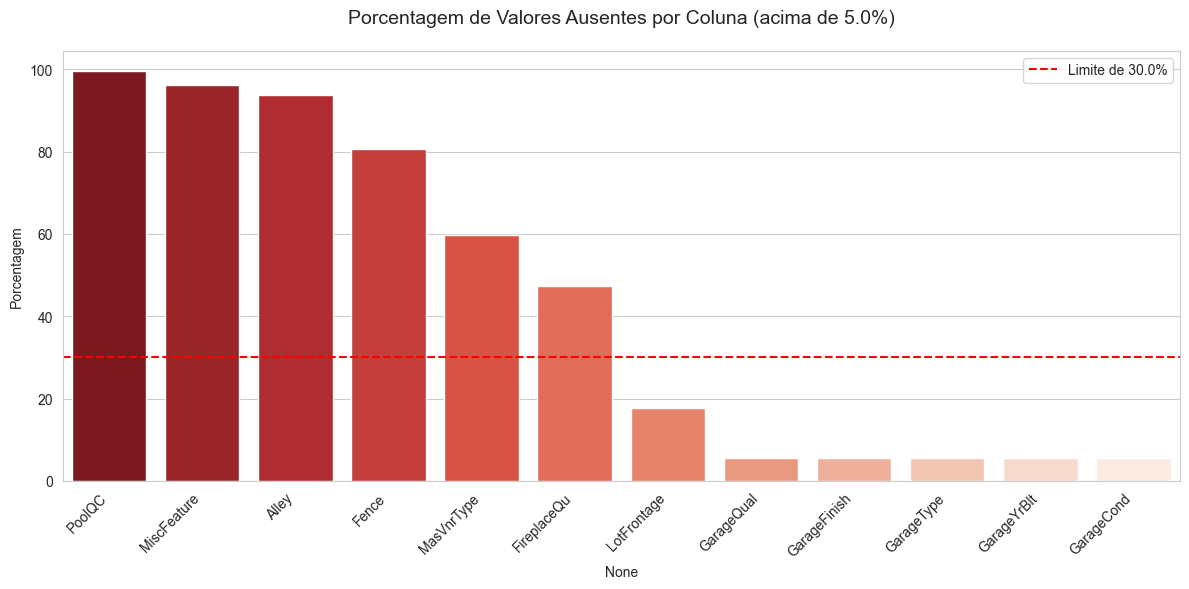




=== Pré-processamento dos Dados ===

Número de features numéricas: 37
Número de features categóricas: 39

=== Visualização dos Dados ===


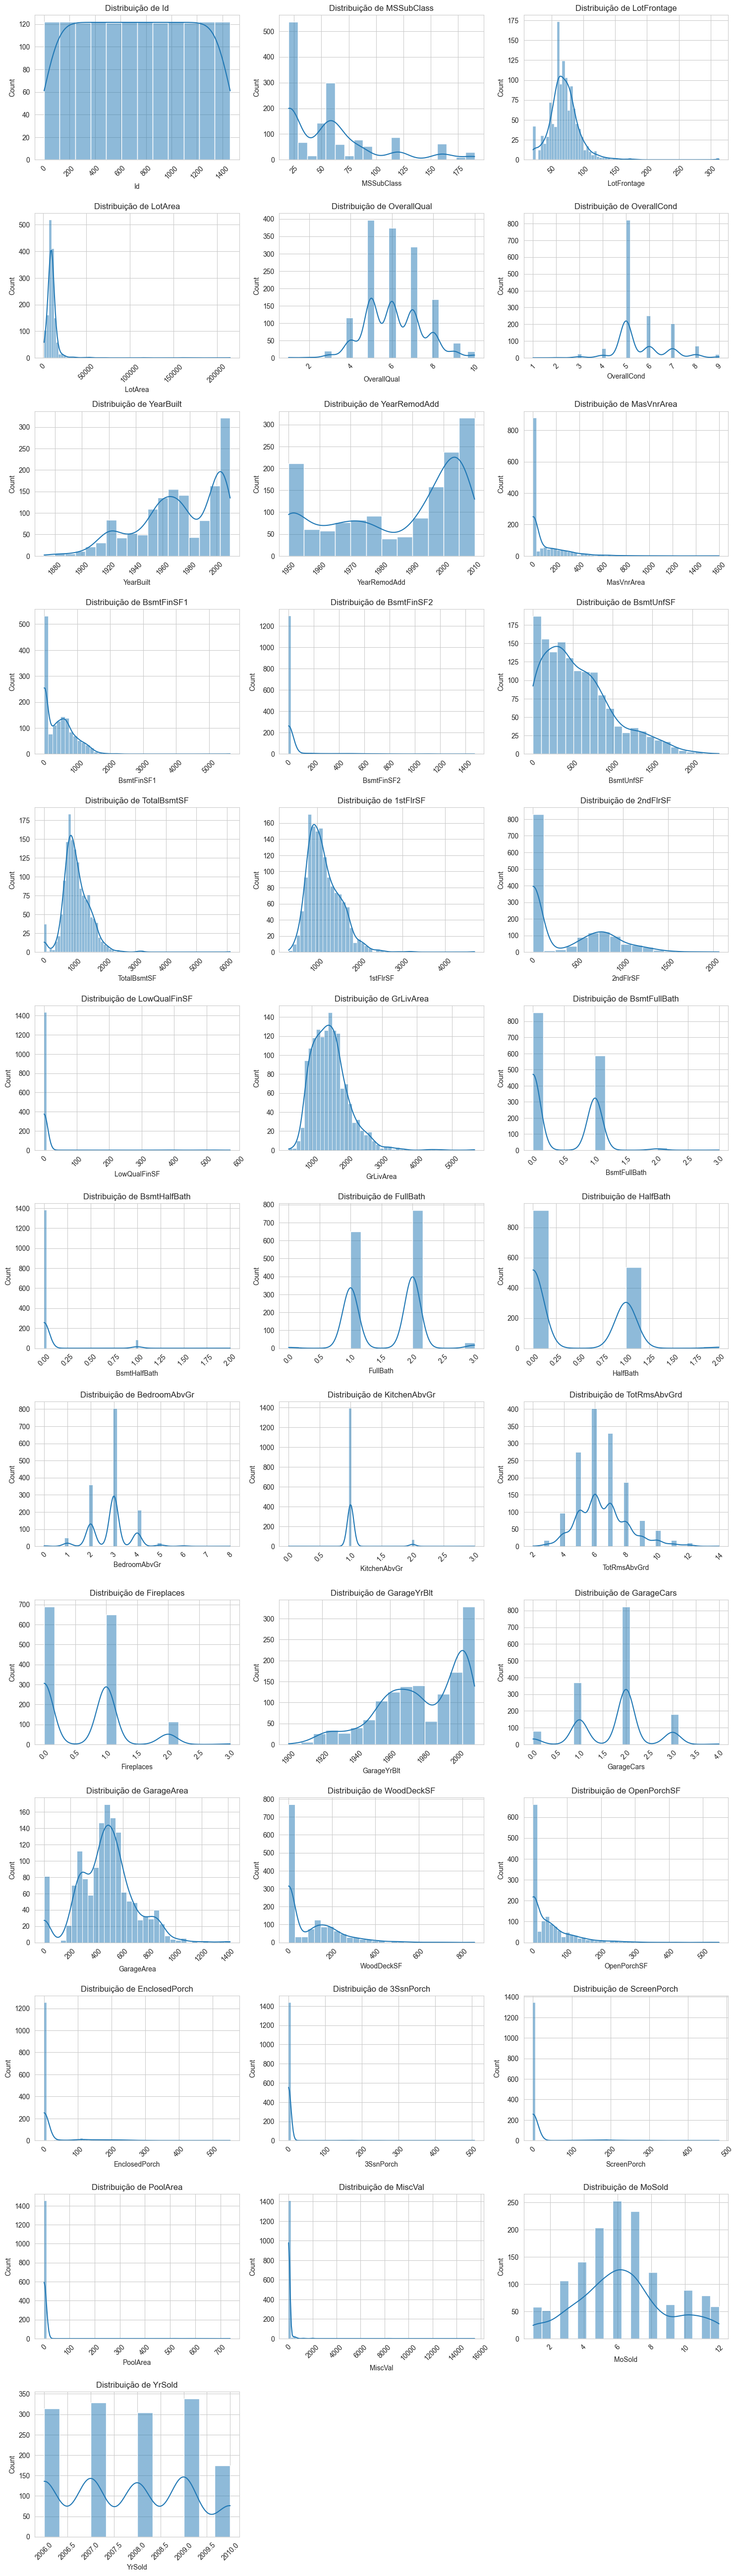

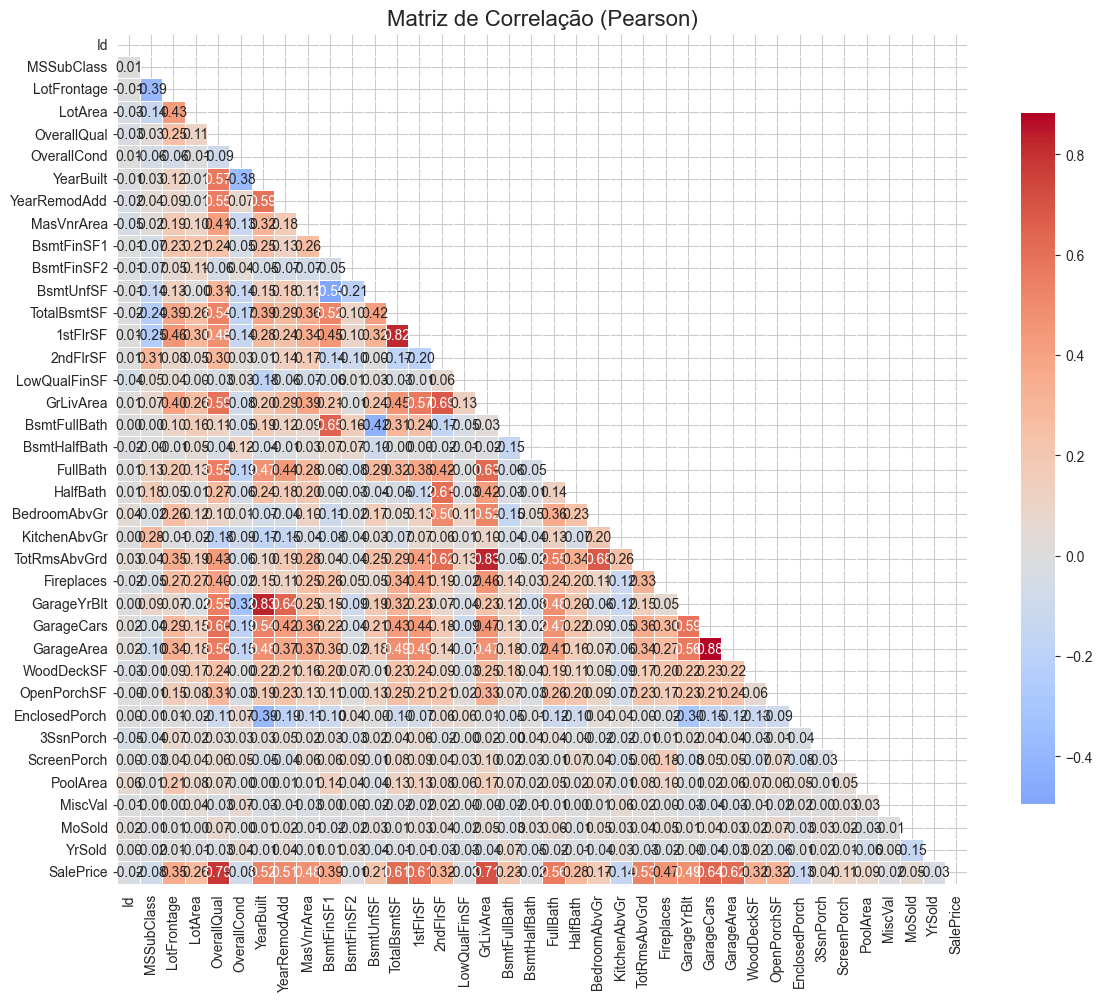


=== Preparação para Modelagem ===

=== Treinamento do Modelo ===
Modelo LinearRegression treinado com sucesso!

=== Avaliação do Modelo ===

Métrica             Treino      Teste
----------------------------------------
MSE             393840723.45 886560482.18
RMSE              19845.42   29775.17
R²                  0.9340     0.8844


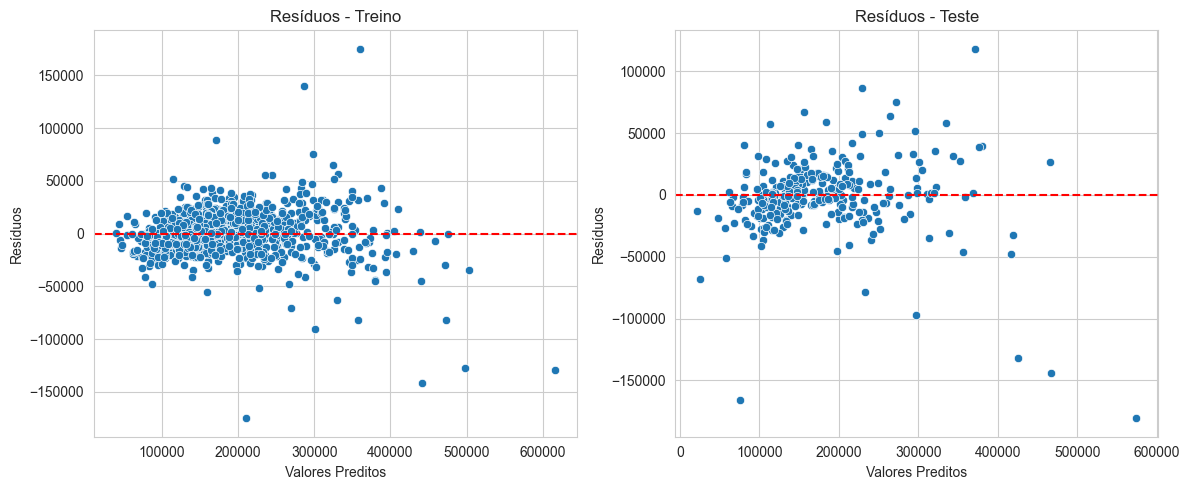

In [11]:
# Configurações iniciais
configurar_exibicao()

# Caminho para os dados
caminho_dados = '../../data/raw'

try:
    # 1. Carregar e analisar dados
    train_df, test_df = carregar_e_analisar_dados(caminho_dados)
    
    # 2. Pré-processar dados
    target_column = 'SalePrice'
    train_processed, numeric_features, categorical_features = preprocessar_dados(
        train_df, target_column
    )
    
    # 3. Visualizar dados
    visualizar_dados(train_processed, numeric_features)
    
    # 4. Preparar dados para modelagem
    X_train, X_test, y_train, y_test, preprocessor = preparar_dados_modelagem(
        train_processed, target_column, numeric_features, categorical_features
    )
    
    # 5. Treinar modelo
    model = treinar_modelo(X_train, y_train, preprocessor)
    
    # 6. Avaliar modelo
    avaliar_modelo(model, X_train, X_test, y_train, y_test)
    
except Exception as e:
    print(f"Ocorreu um erro: {str(e)}")
    raise